<img style="float: middle;" src="../images/logo.png">

In [1]:
import time
start = time.time()

## 1. Import package and load the data

In [2]:
import stlearn as st
from pathlib import Path
import pandas as pd
import numpy as np
import anndata
import matplotlib.pyplot as plt
import scanpy as sc
st.settings.set_figure_params(dpi=180)

/home/uqxtan9/micromamba/envs/spatialdata/lib/python3.10/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


In [6]:
# specify PATH to data
DATA_PATH = Path("/data/module2/data/Visium")

In [7]:
# load data
data = st.Read10X(DATA_PATH / "VLP108_A/outs", library_id="VLP108_A")
data.layers["raw_count"] = data.X
data.raw = data

/opt/anaconda3/envs/stimage2/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/stimage2/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### 1.2 pre-processing, dimensionality reduction and Clustering

Normalization step is finished in adata.X
Log transformation step is finished in adata.X


/opt/anaconda3/envs/stimage2/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:485: UserWarning: Ignoring auto and using arpack, sklearn.decomposition.PCA (with sparse input) only supports {'arpack', 'lobpcg'}
  warnings.warn(


PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


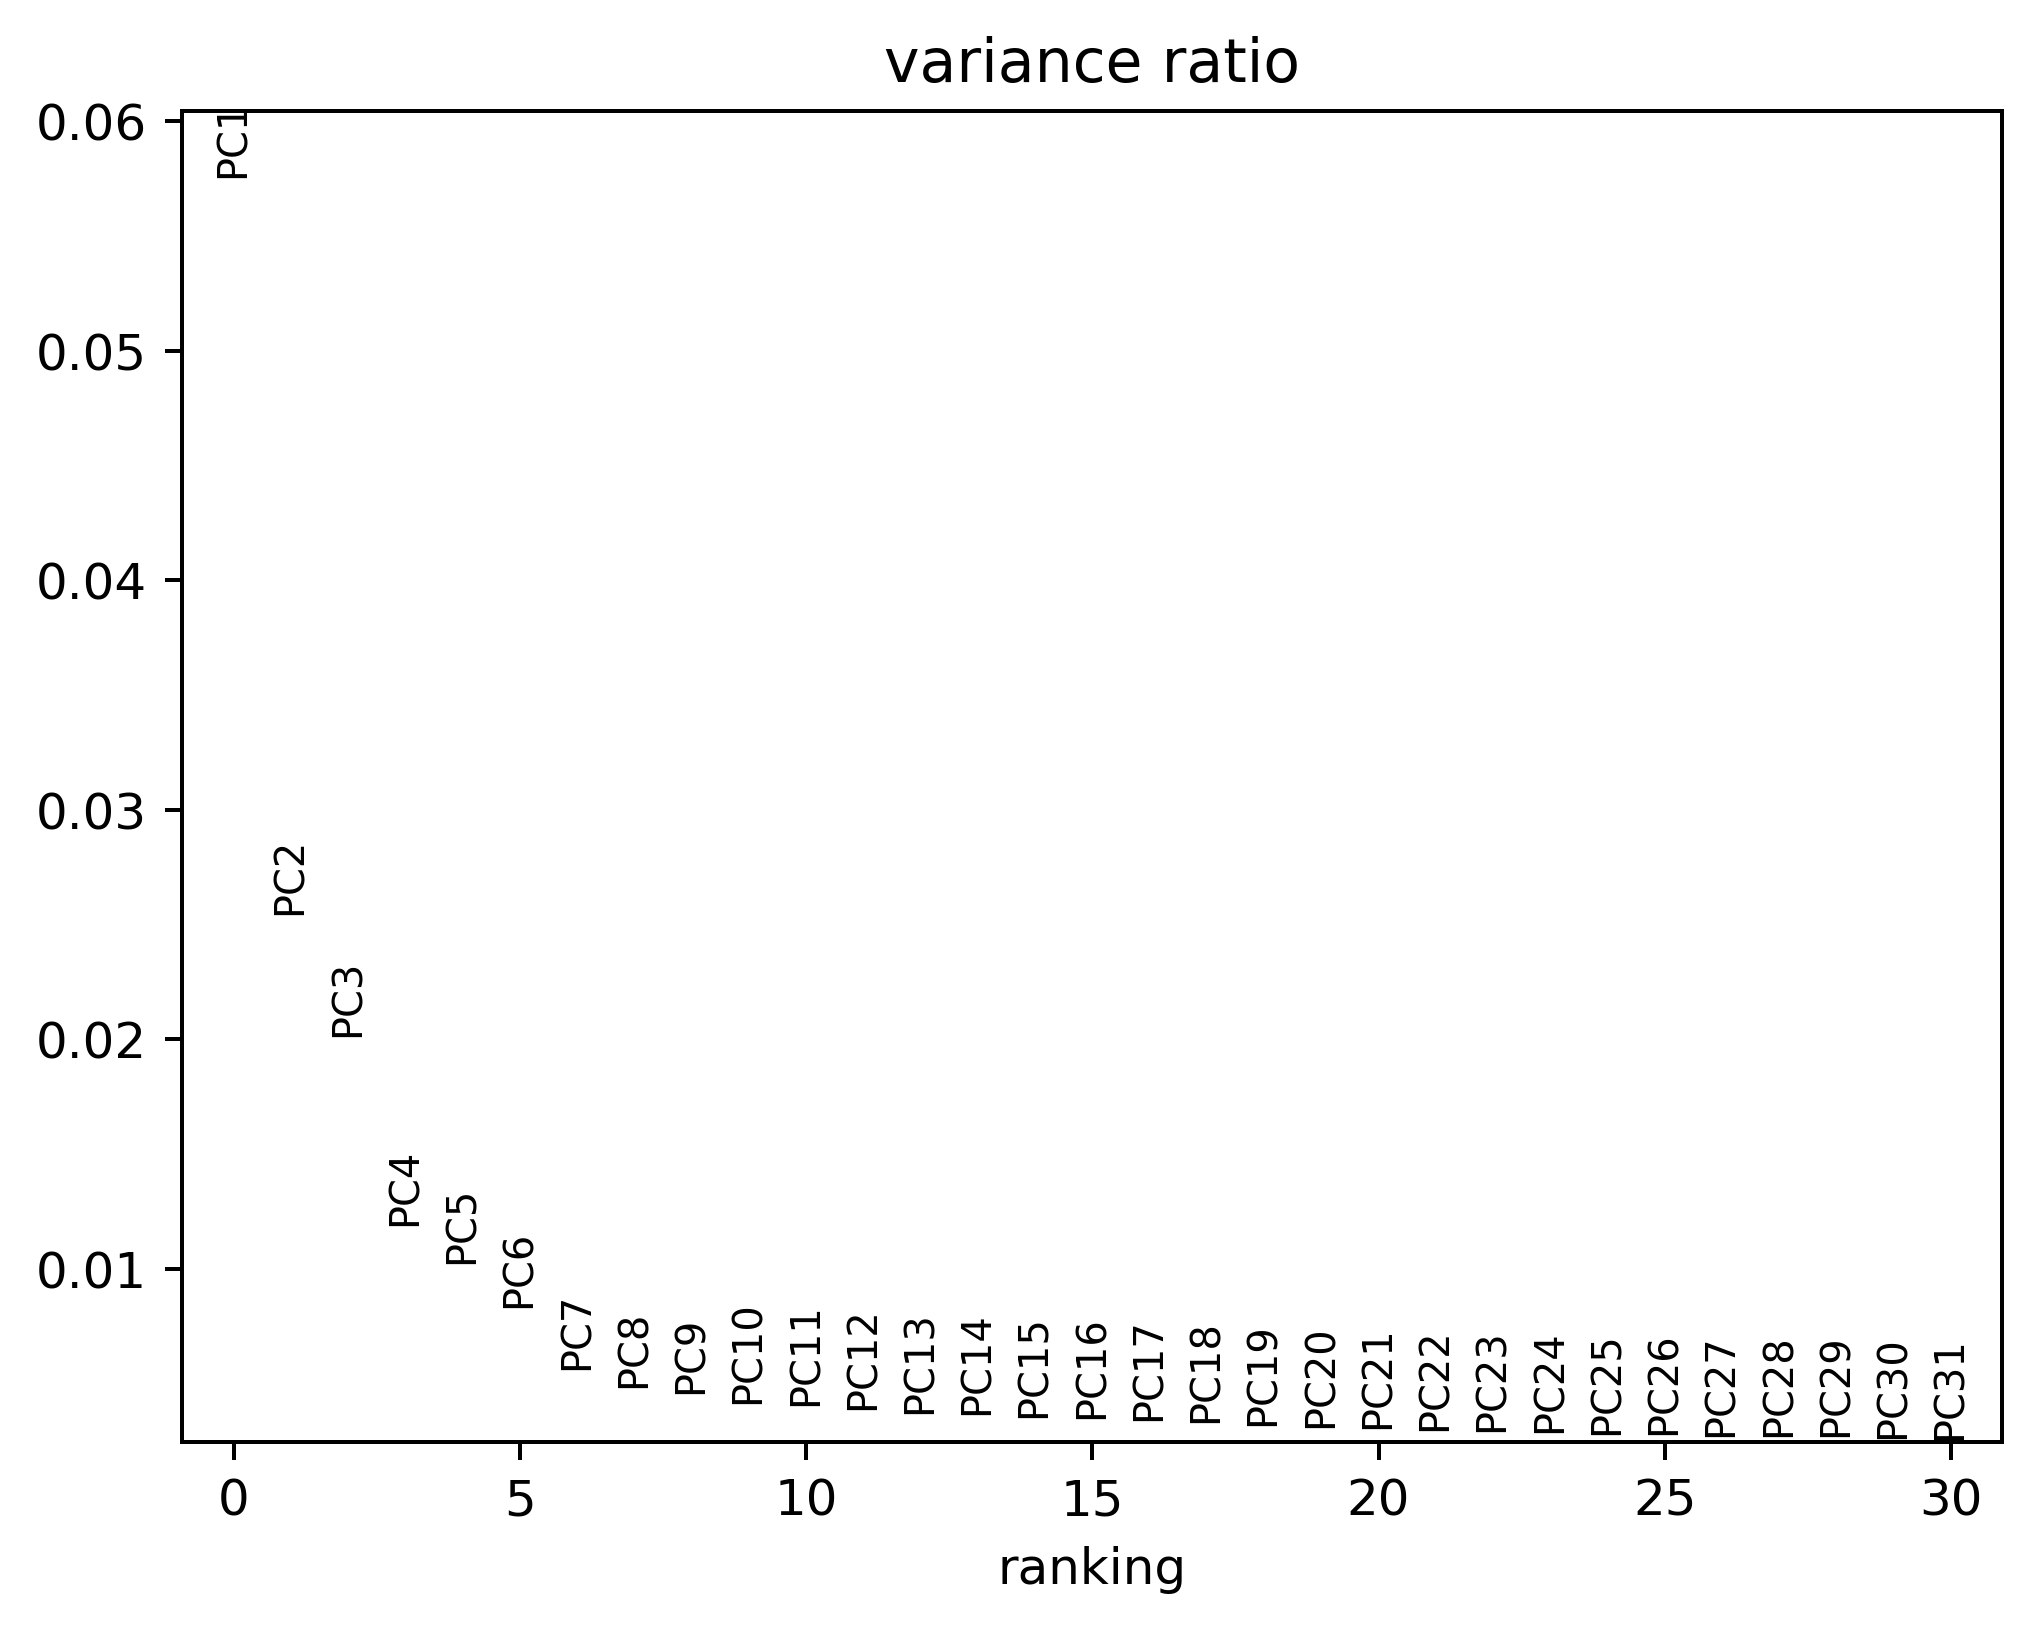

In [8]:
# pre-processing for gene count table
st.pp.filter_genes(data,min_cells=1)
st.pp.normalize_total(data)
st.pp.log1p(data)

# run PCA for gene expression data
st.em.run_pca(data,n_comps=50)

sc.pl.pca_variance_ratio(data)

2024-05-31 08:23:01.860927: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-31 08:23:01.863874: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-31 08:23:01.896516: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 08:23:01.896545: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 08:23:01.896567: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


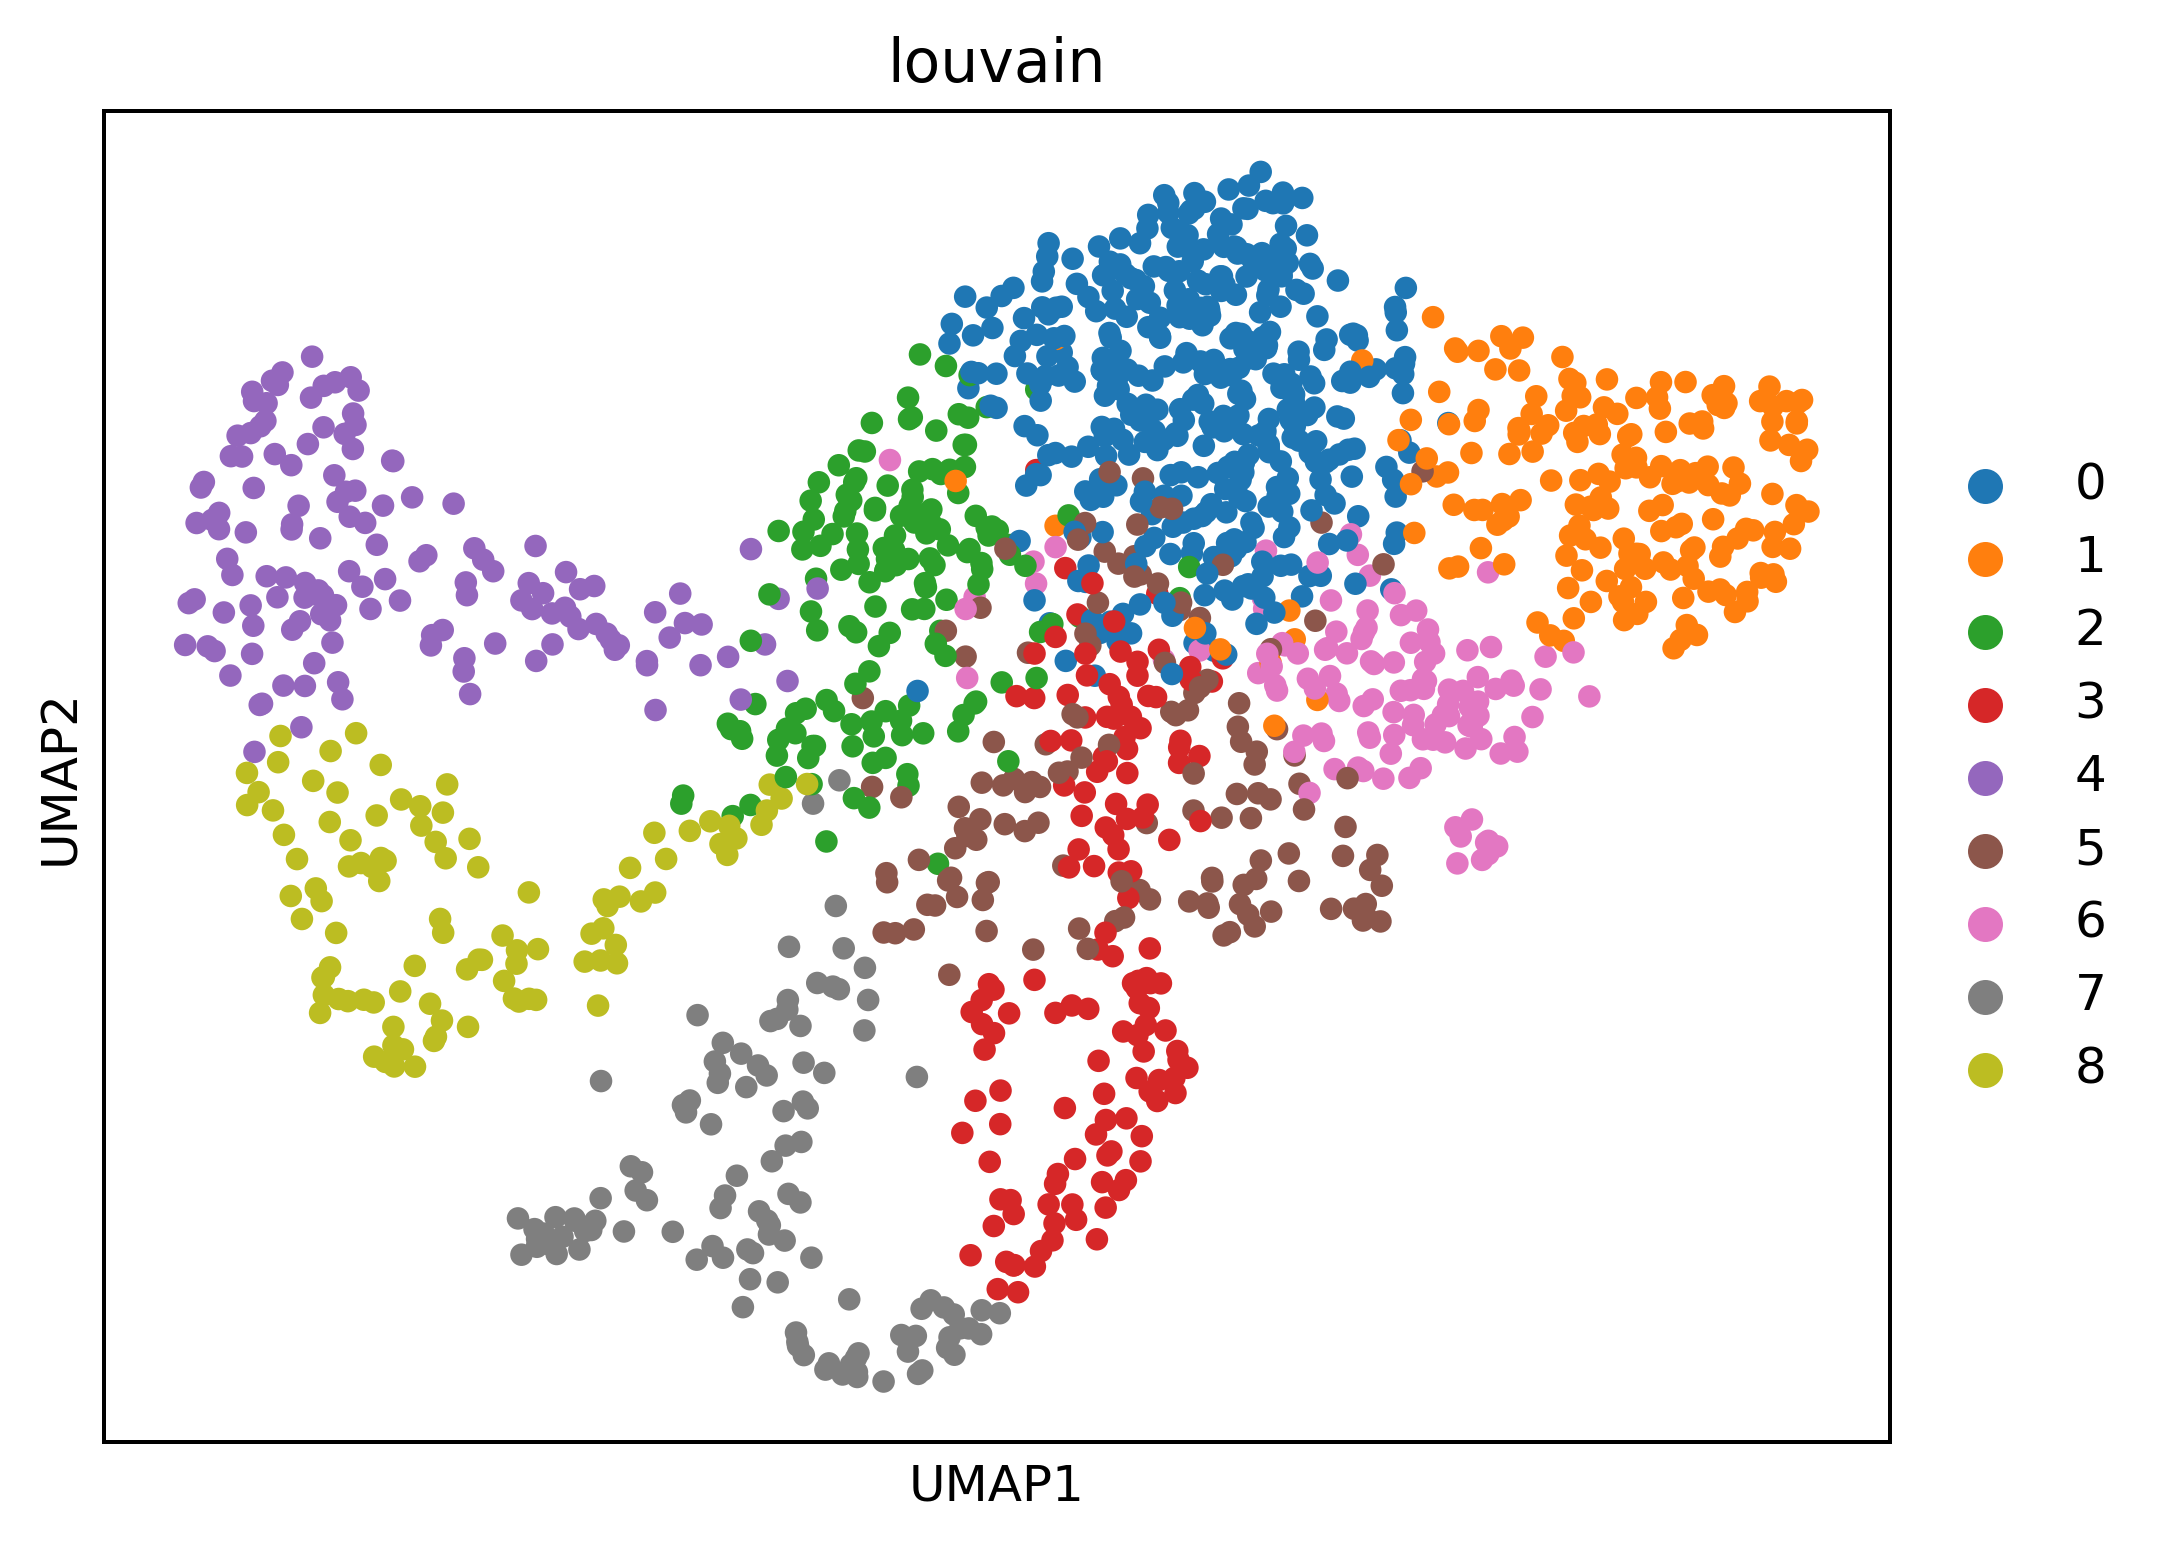

/opt/anaconda3/envs/stimage2/lib/python3.10/site-packages/stlearn/plotting/classes.py:733: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, cluster in enumerate(self.query_adata.obs.groupby(self.use_label)):


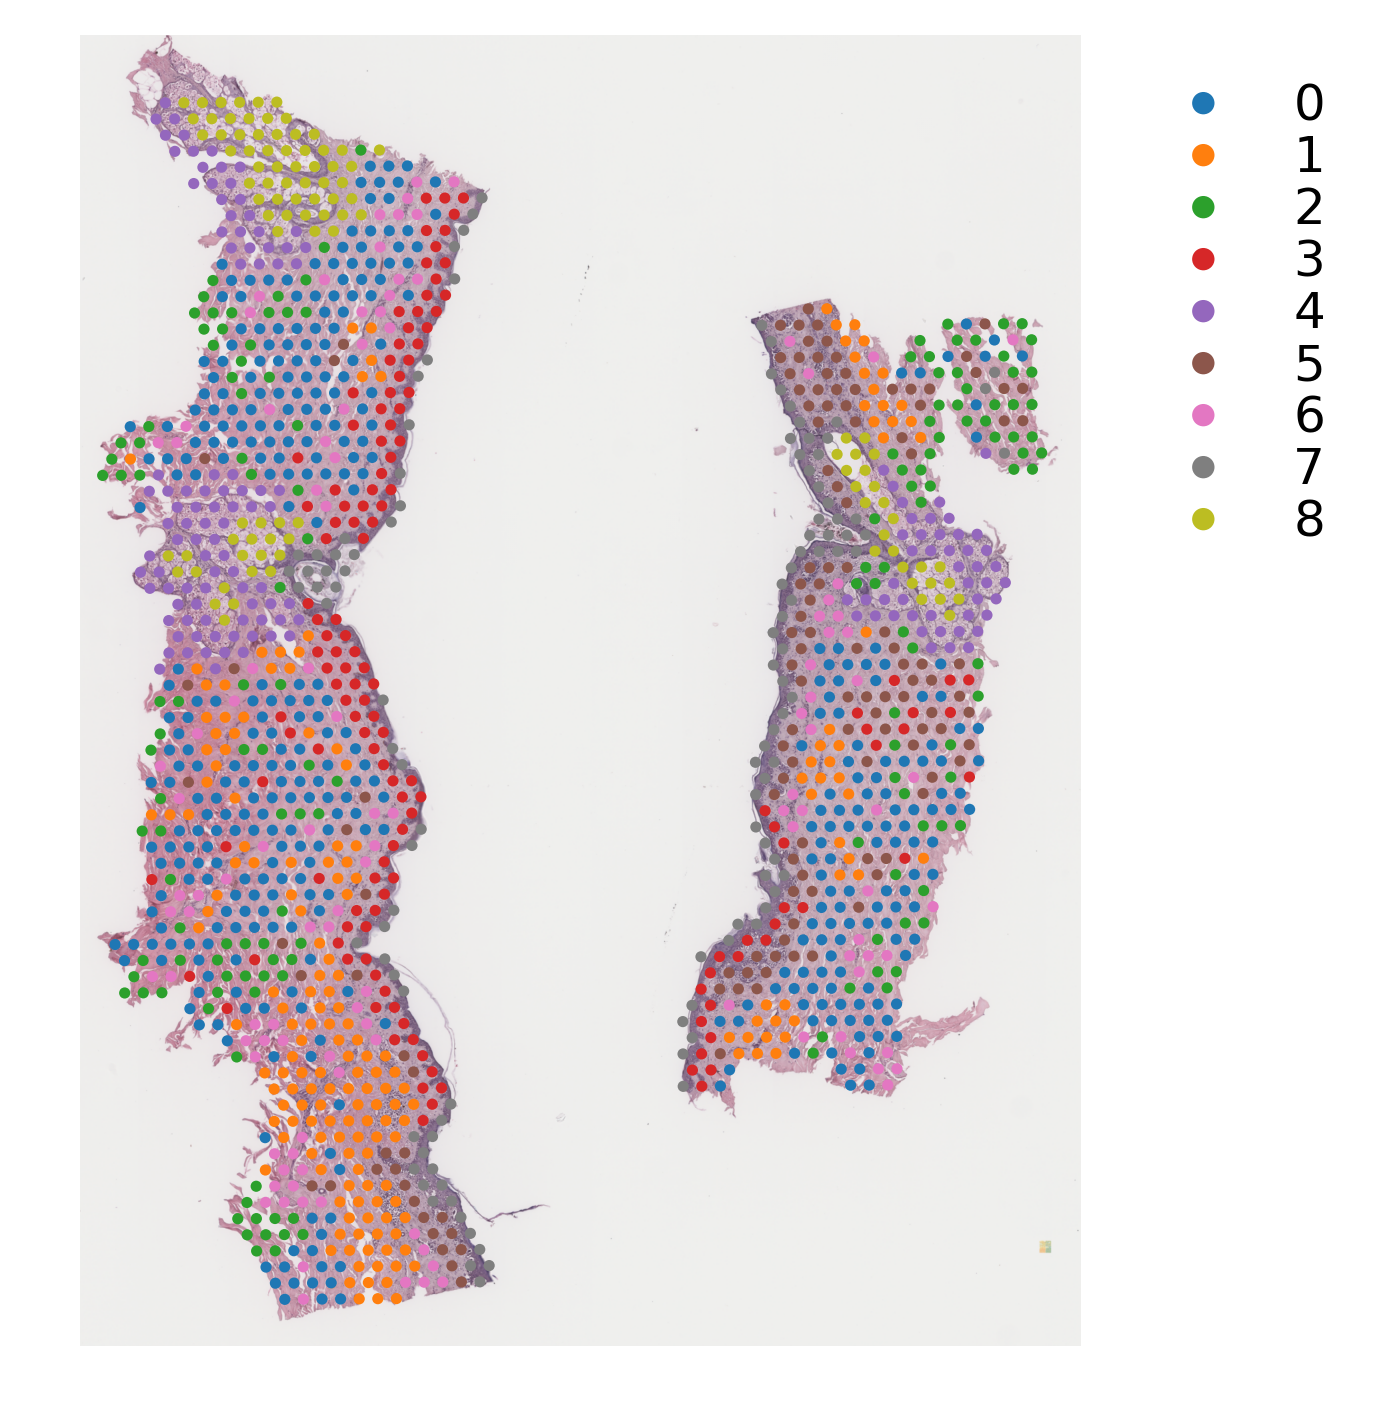

In [9]:
st.pp.neighbors(data,n_neighbors=20,use_rep='X_pca',random_state=0)
sc.tl.umap(data)
st.tl.clustering.louvain(data)
sc.pl.umap(data, color="louvain")
st.pl.cluster_plot(data,use_label="louvain")

### 1.3 Build an autoencoder to denoise the data and reduce dimension

In [10]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Model

In [11]:
# split the training and test dataset
x_train, x_test = train_test_split(data.to_df(), test_size=0.3, random_state=1)

In [12]:
# define model parameters
feature_dim = len(x_train.columns)  ### number of genes
latent_dim = [128, 64]              ### number of neurons in each layers

# build the autoencoder
class Autoencoder(Model):
    def __init__(self, feature_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.feature_dim = feature_dim
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
          layers.InputLayer(input_shape=(feature_dim,)),
          layers.Dense(latent_dim[0], activation='relu'),
          layers.Dense(latent_dim[1], activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.InputLayer(input_shape=(latent_dim[1],)),
          layers.Dense(latent_dim[0], activation='relu'),
          layers.Dense(feature_dim, activation='linear'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [13]:
autoencoder = Autoencoder(feature_dim, latent_dim)

2024-05-31 08:23:25.892162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-31 08:23:25.910033: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [14]:
# compile model
autoencoder.compile(optimizer=optimizers.Adam(learning_rate=1e-5), 
                    loss=losses.MeanSquaredError())

In [15]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2114304   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
Total params: 2122560 (8.10 MB)
Trainable params: 2122560 (8.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 16517)             2130693   
                                                                 
Total params: 2139013 (8.16 MB)
Trainable params: 2139013 (8.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# train model
training_history = autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=16,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/20
65/65 [==============================] - 3s 35ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 2/20
65/65 [==============================] - 2s 33ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 3/20
65/65 [==============================] - 2s 36ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 4/20
65/65 [==============================] - 2s 37ms/step - loss: 0.0111 - val_loss: 0.0106
Epoch 5/20
65/65 [==============================] - 2s 34ms/step - loss: 0.0109 - val_loss: 0.0103
Epoch 6/20
65/65 [==============================] - 2s 32ms/step - loss: 0.0106 - val_loss: 0.0099
Epoch 7/20
65/65 [==============================] - 3s 49ms/step - loss: 0.0102 - val_loss: 0.0096
Epoch 8/20
65/65 [==============================] - 4s 57ms/step - loss: 0.0099 - val_loss: 0.0094
Epoch 9/20
65/65 [==============================] - 3s 44ms/step - loss: 0.0097 - val_loss: 0.0093
Epoch 10/20
65/65 [==============================] - 4s 58ms/step - loss: 0.0096 - val_loss: 0.0092
Epoch 11/

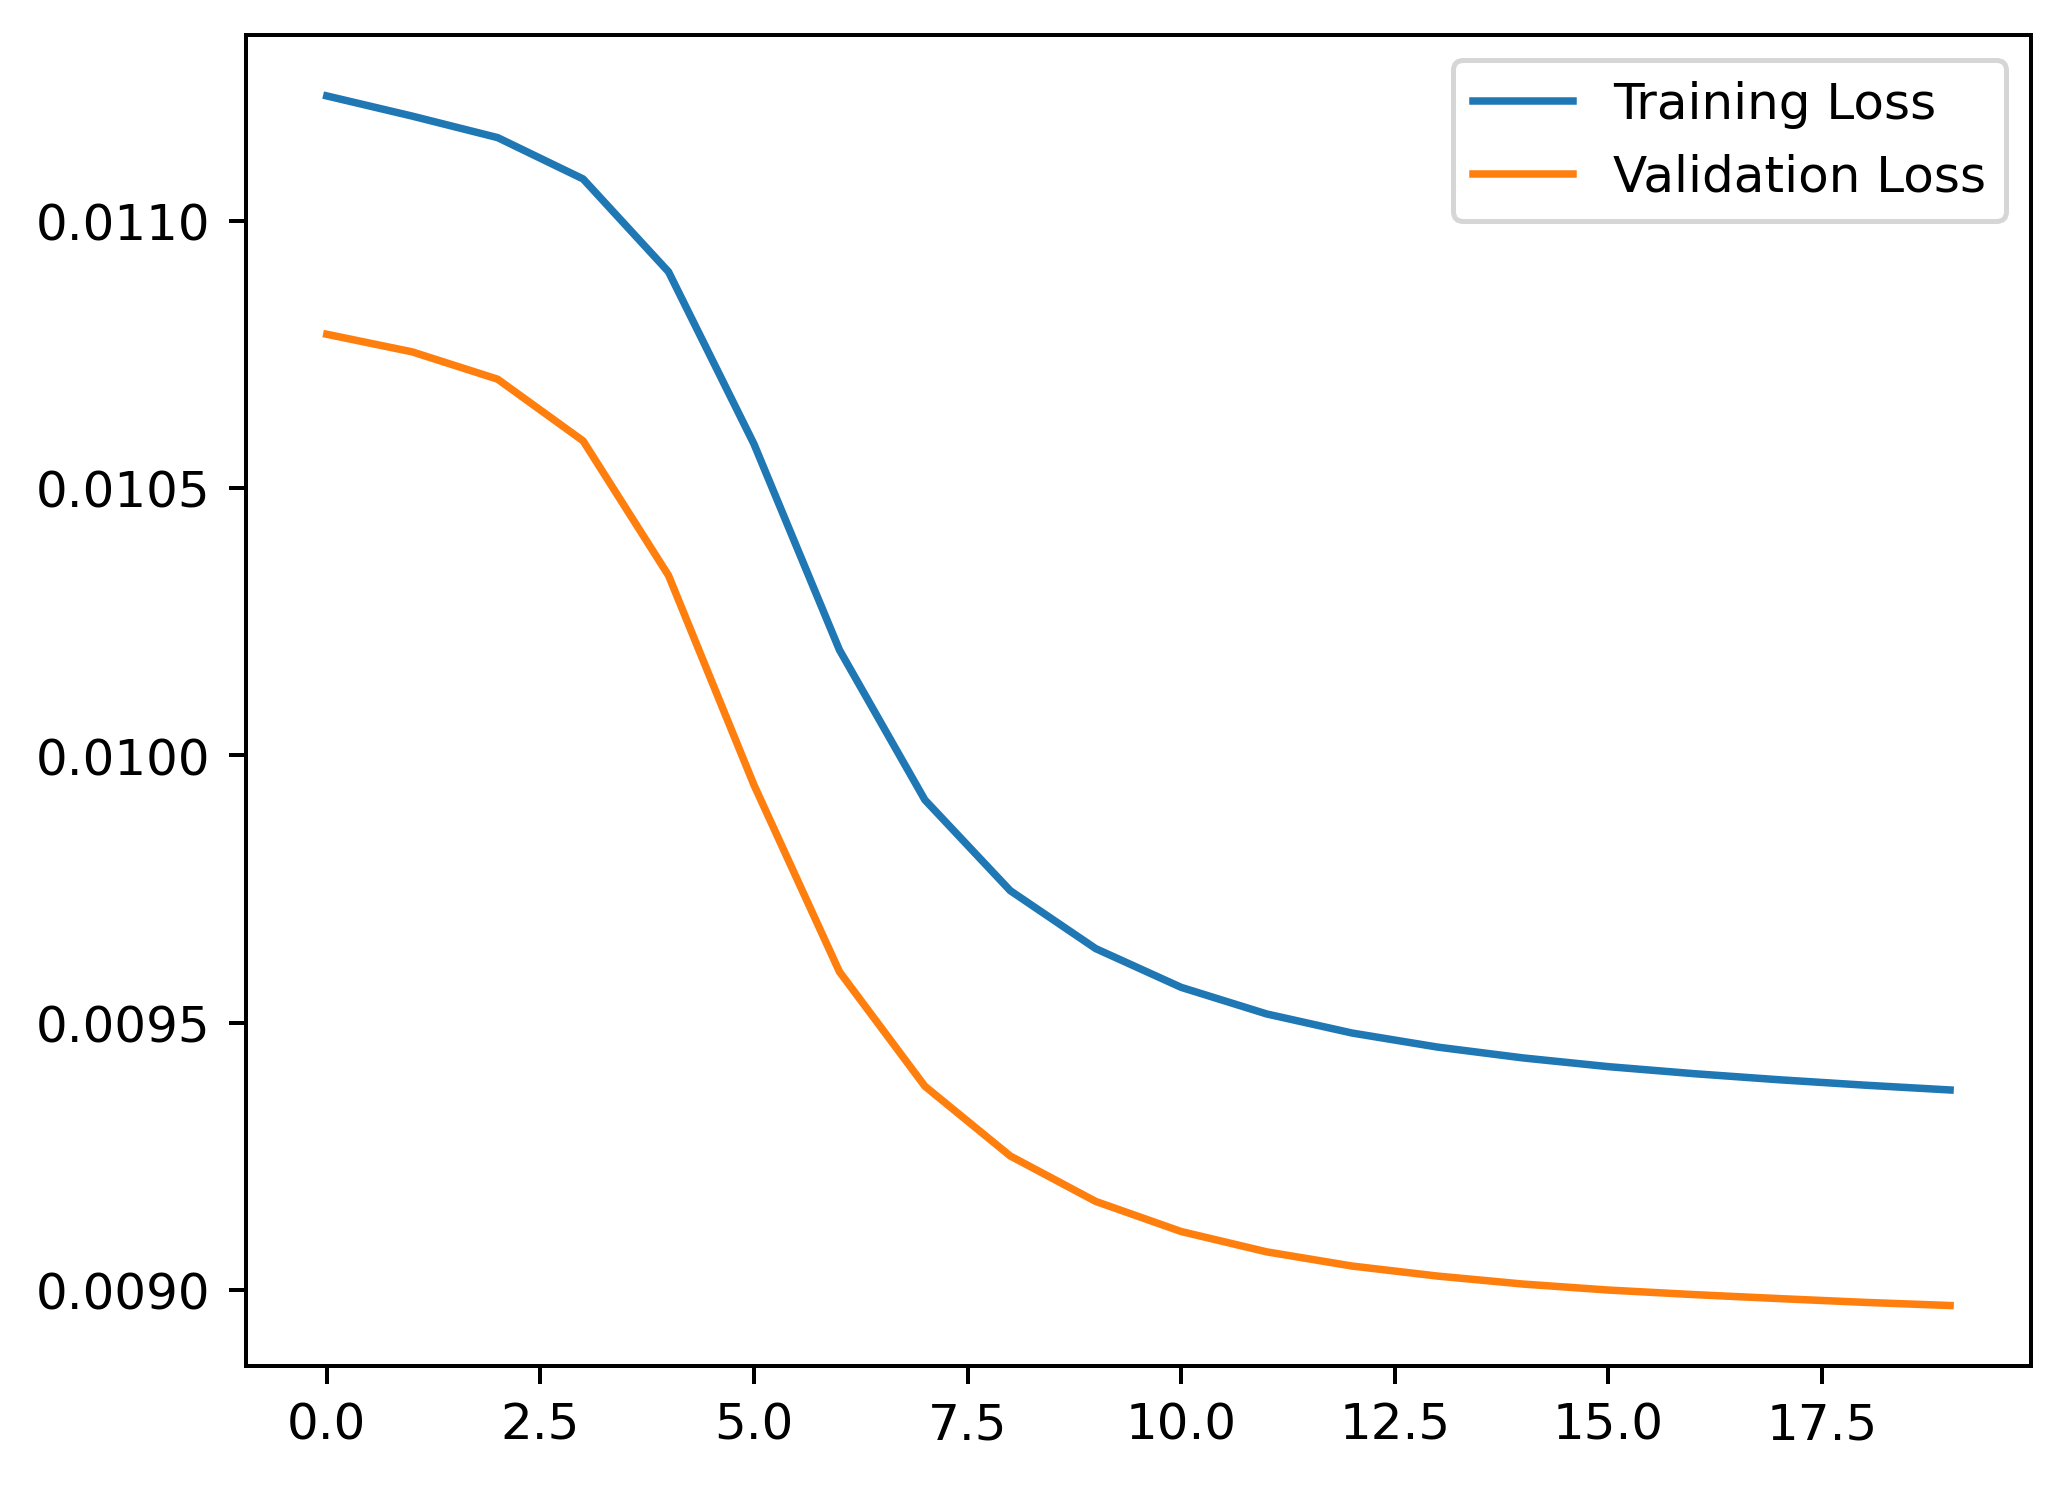

In [18]:
plt.plot(training_history.history["loss"], label="Training Loss")
plt.plot(training_history.history["val_loss"], label="Validation Loss")
plt.legend()

In [19]:
reconstructions = autoencoder.predict(data.to_df())

47/47 [==============================] - 0s 6ms/step


In [20]:
data_reconstructions = data.copy()
data_reconstructions.X = reconstructions

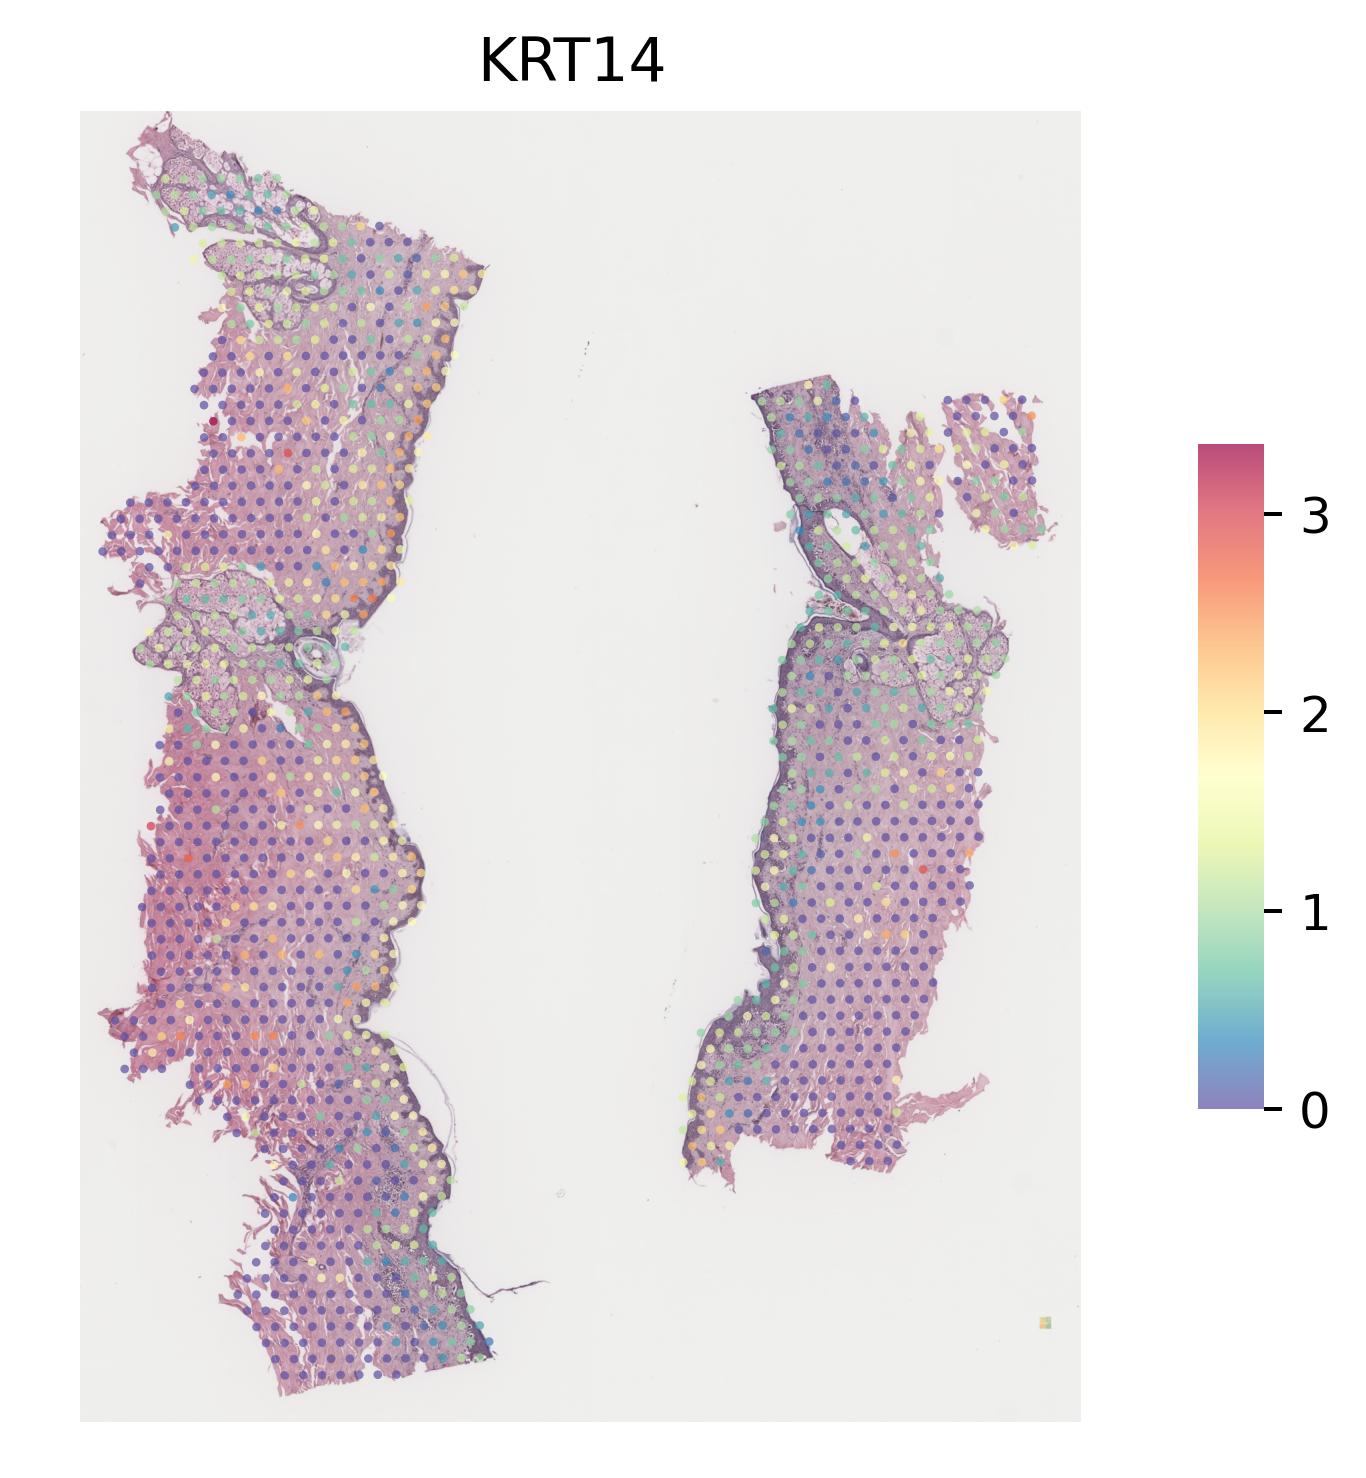

In [27]:
# visualise the original gene expression
st.pl.gene_plot(data, gene_symbols="KRT14", size=3)

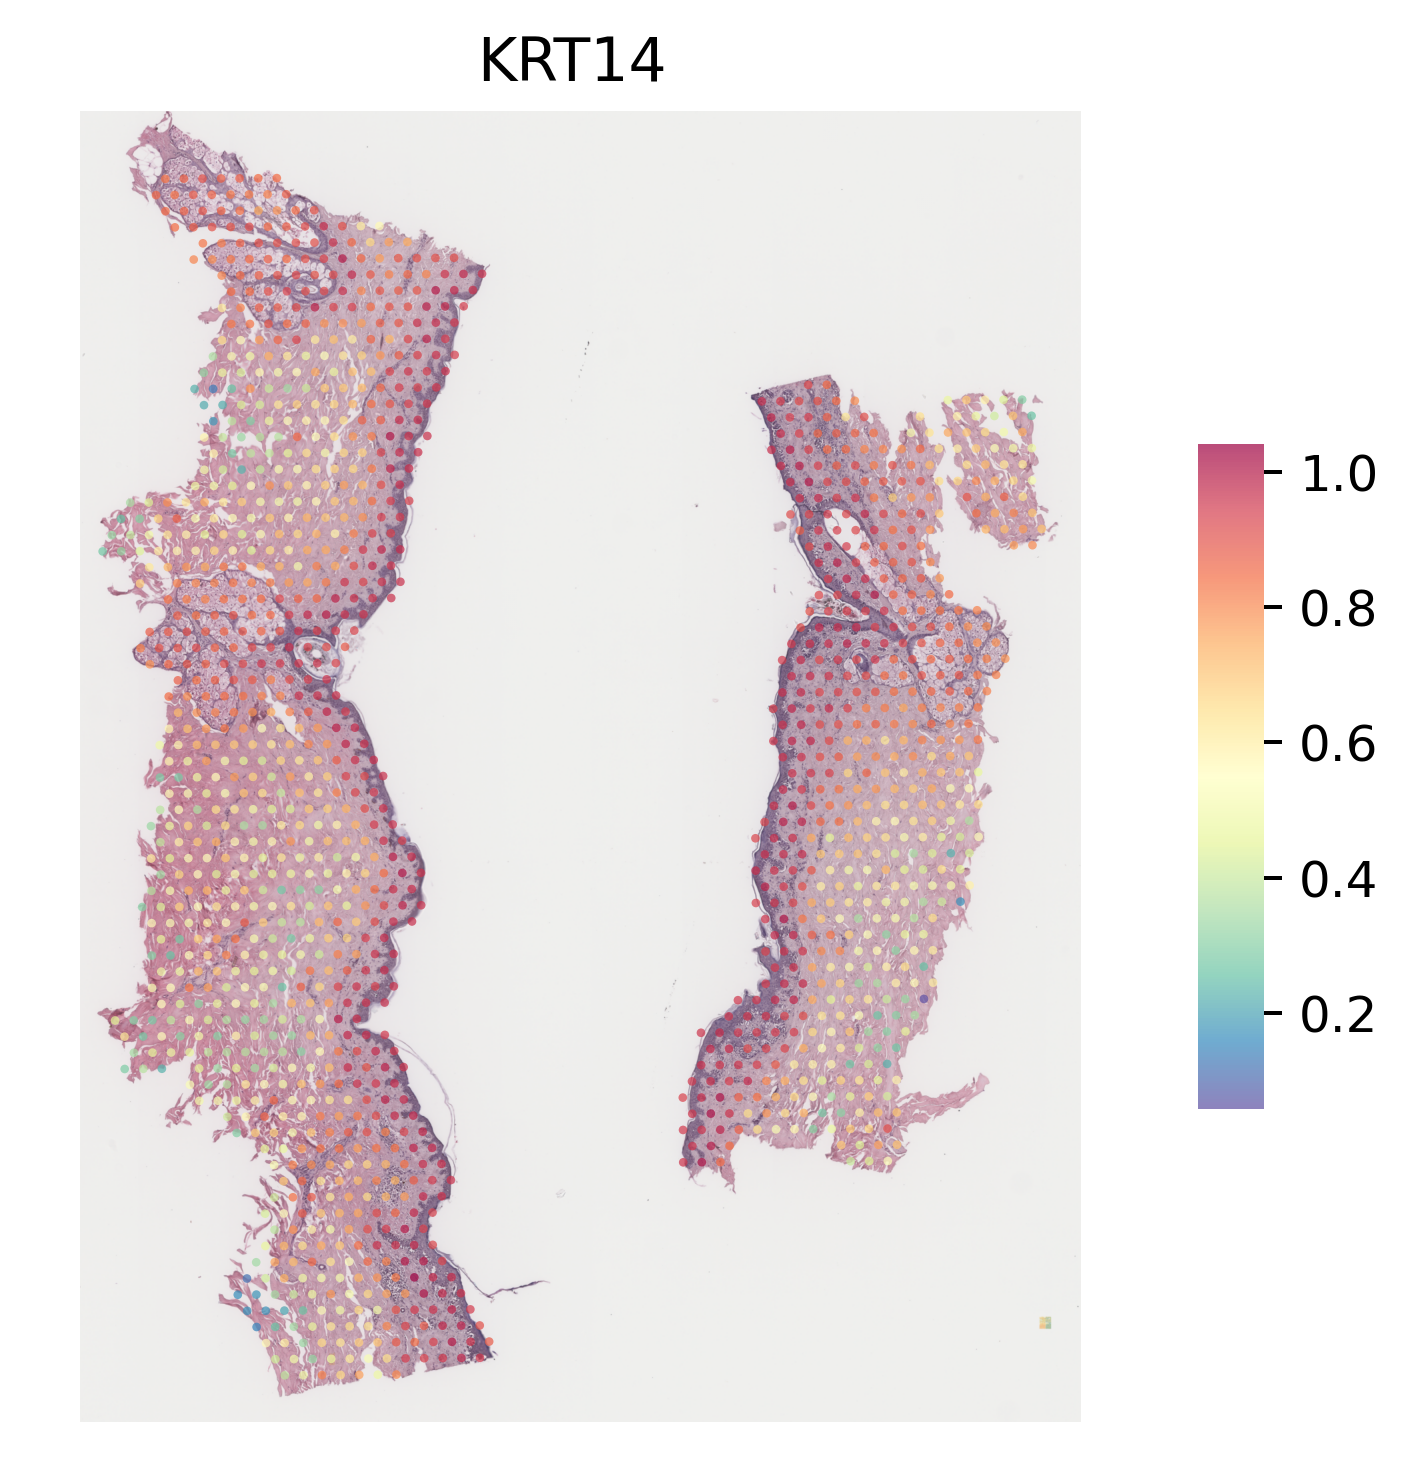

In [28]:
# visualise the reconstructed gene expression
st.pl.gene_plot(data_reconstructions, gene_symbols="KRT14", size=3)

In [25]:
# visualize the latent features in umap space
st.em.run_pca(data_reconstructions,n_comps=50)
st.pp.neighbors(data_reconstructions,n_neighbors=20,use_rep='X_pca',random_state=0)
sc.tl.umap(data_reconstructions)

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 


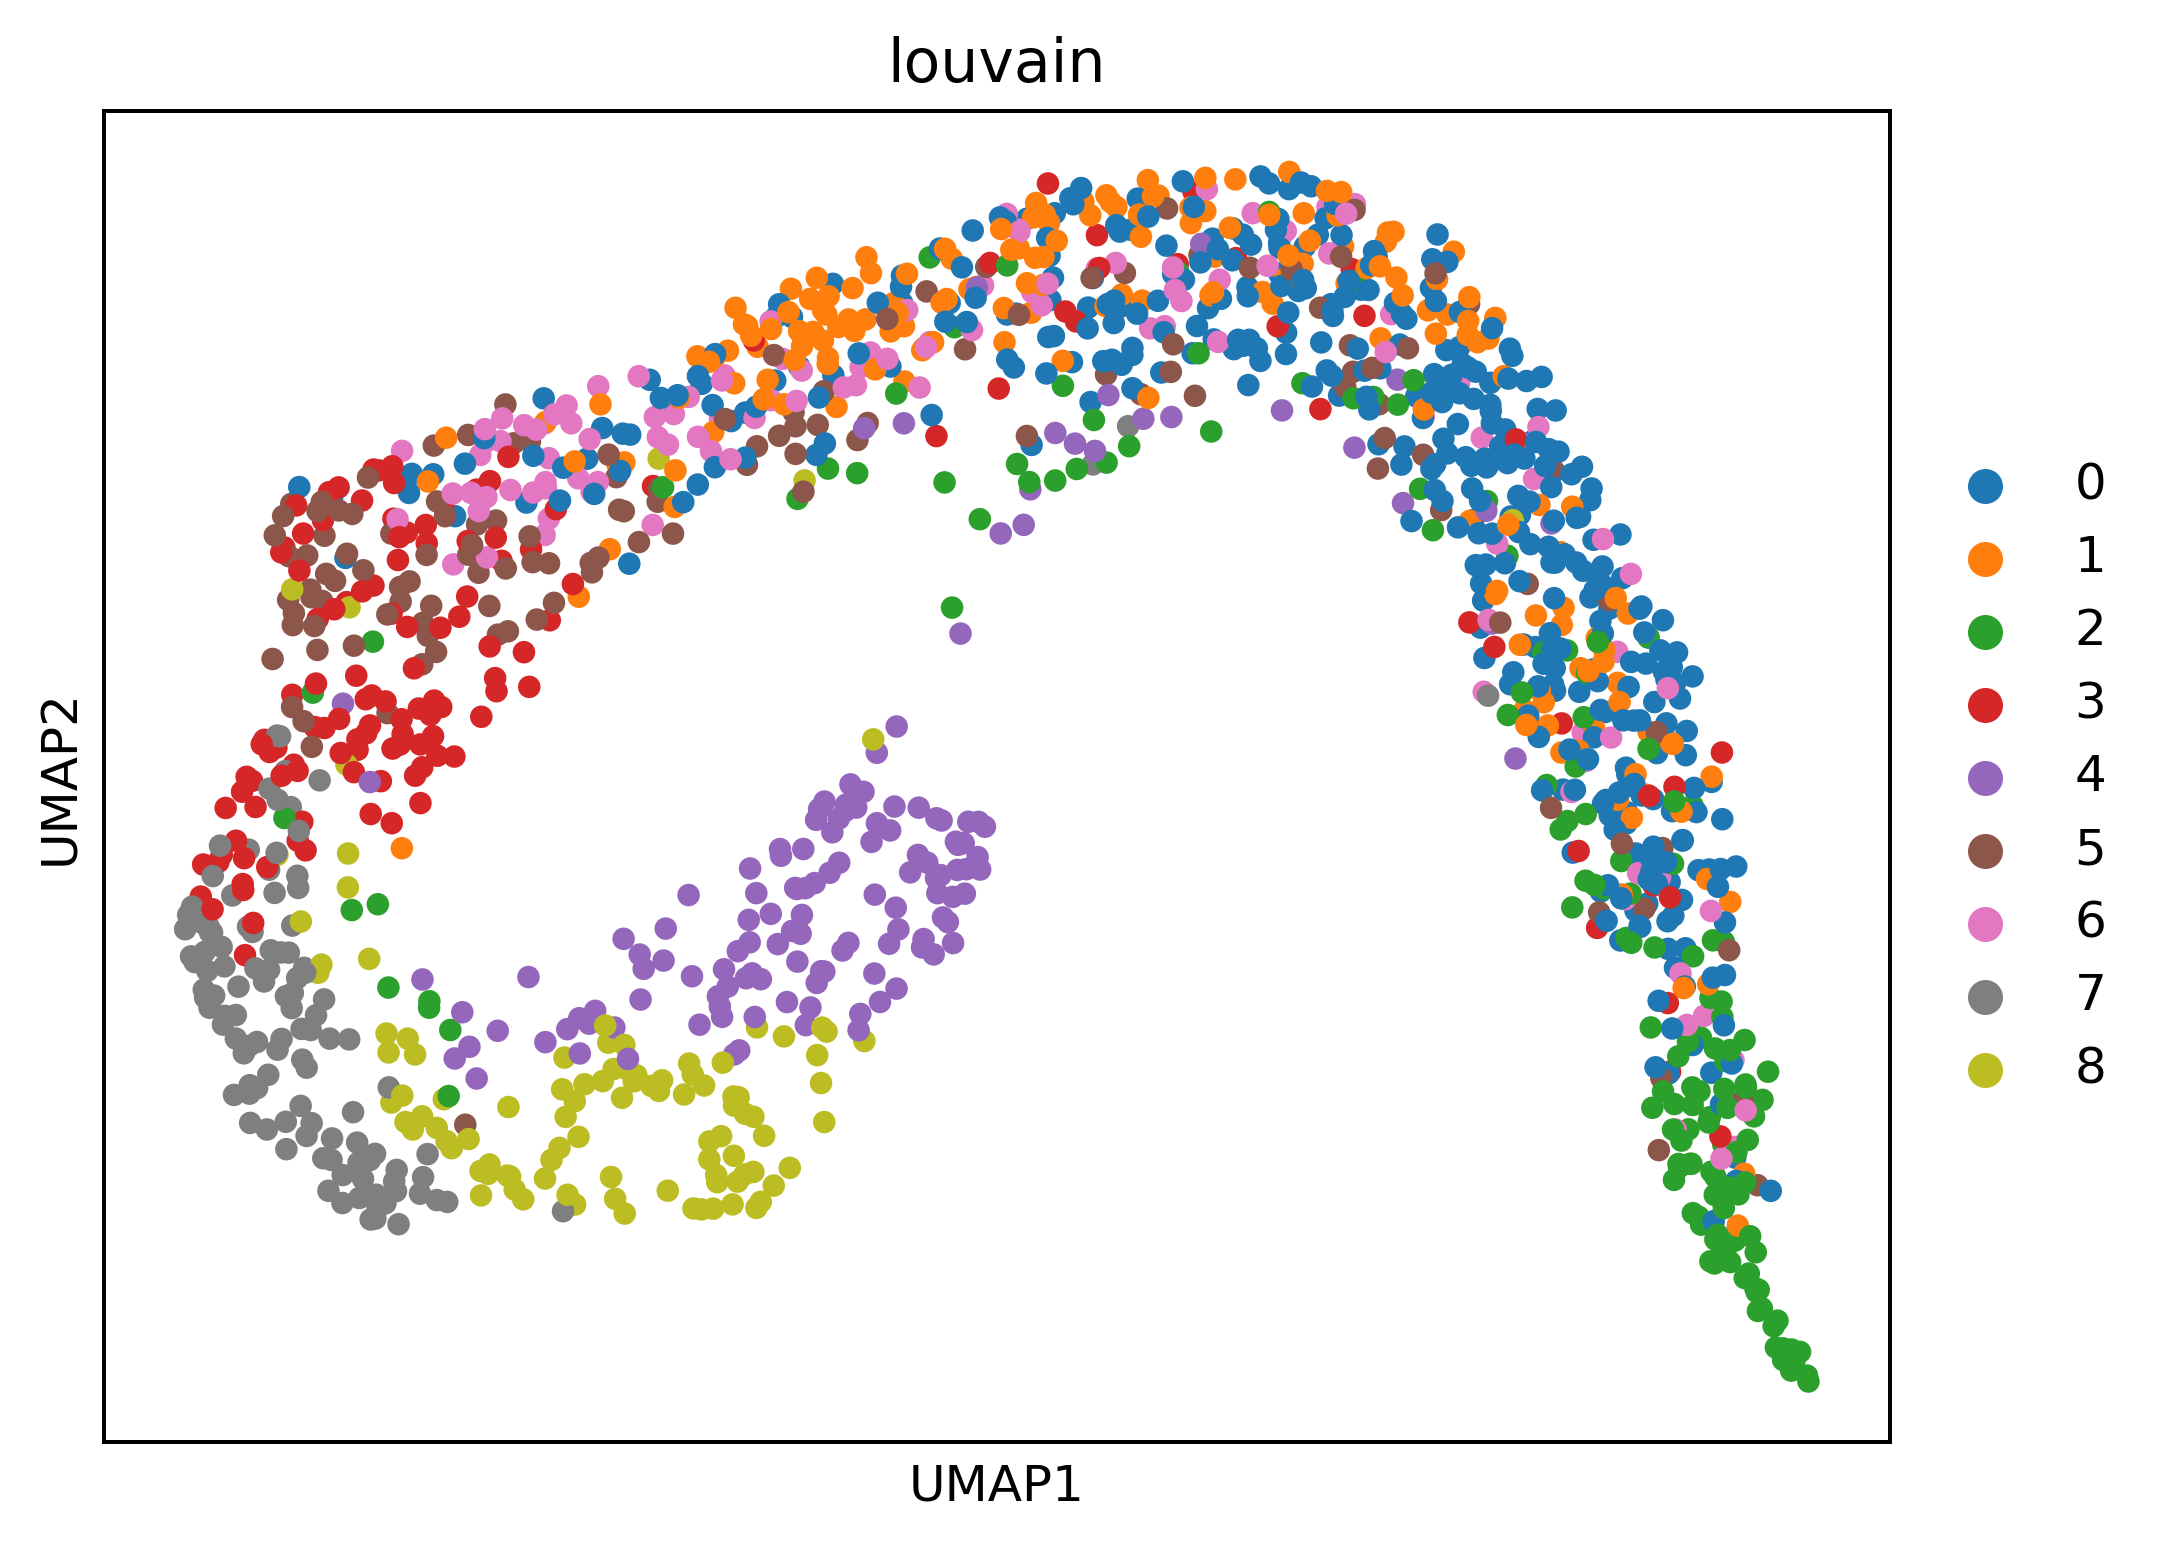

In [26]:
sc.pl.umap(data_reconstructions, color="louvain")

In [ ]:
# !git clone https://github.com/yenan/her2_analysis
# %cd her2_analysis

### 2. A CNN model to predict cell typ from HE images
The provided dataset contains multiple spots in the histology images of several tissues and the labels of these spots.

The code below shows how you can load and use the data.

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

def load_her2():
    X = []
    for i in range(7):
        with open(f'/data/module2/data/DeepLearning/X{i}.pkl', 'rb') as f:
            X.append(pkl.load(f))
    y = pkl.load(open(f'/data/module2/data/DeepLearning/y{i}.pkl', 'rb'))
    return X, y

In [37]:
X, y = load_her2()

7 tissues
346 spots in the first tissue
Label for the first spot in the first tissue: 0
Image for the first spot in the first tissue


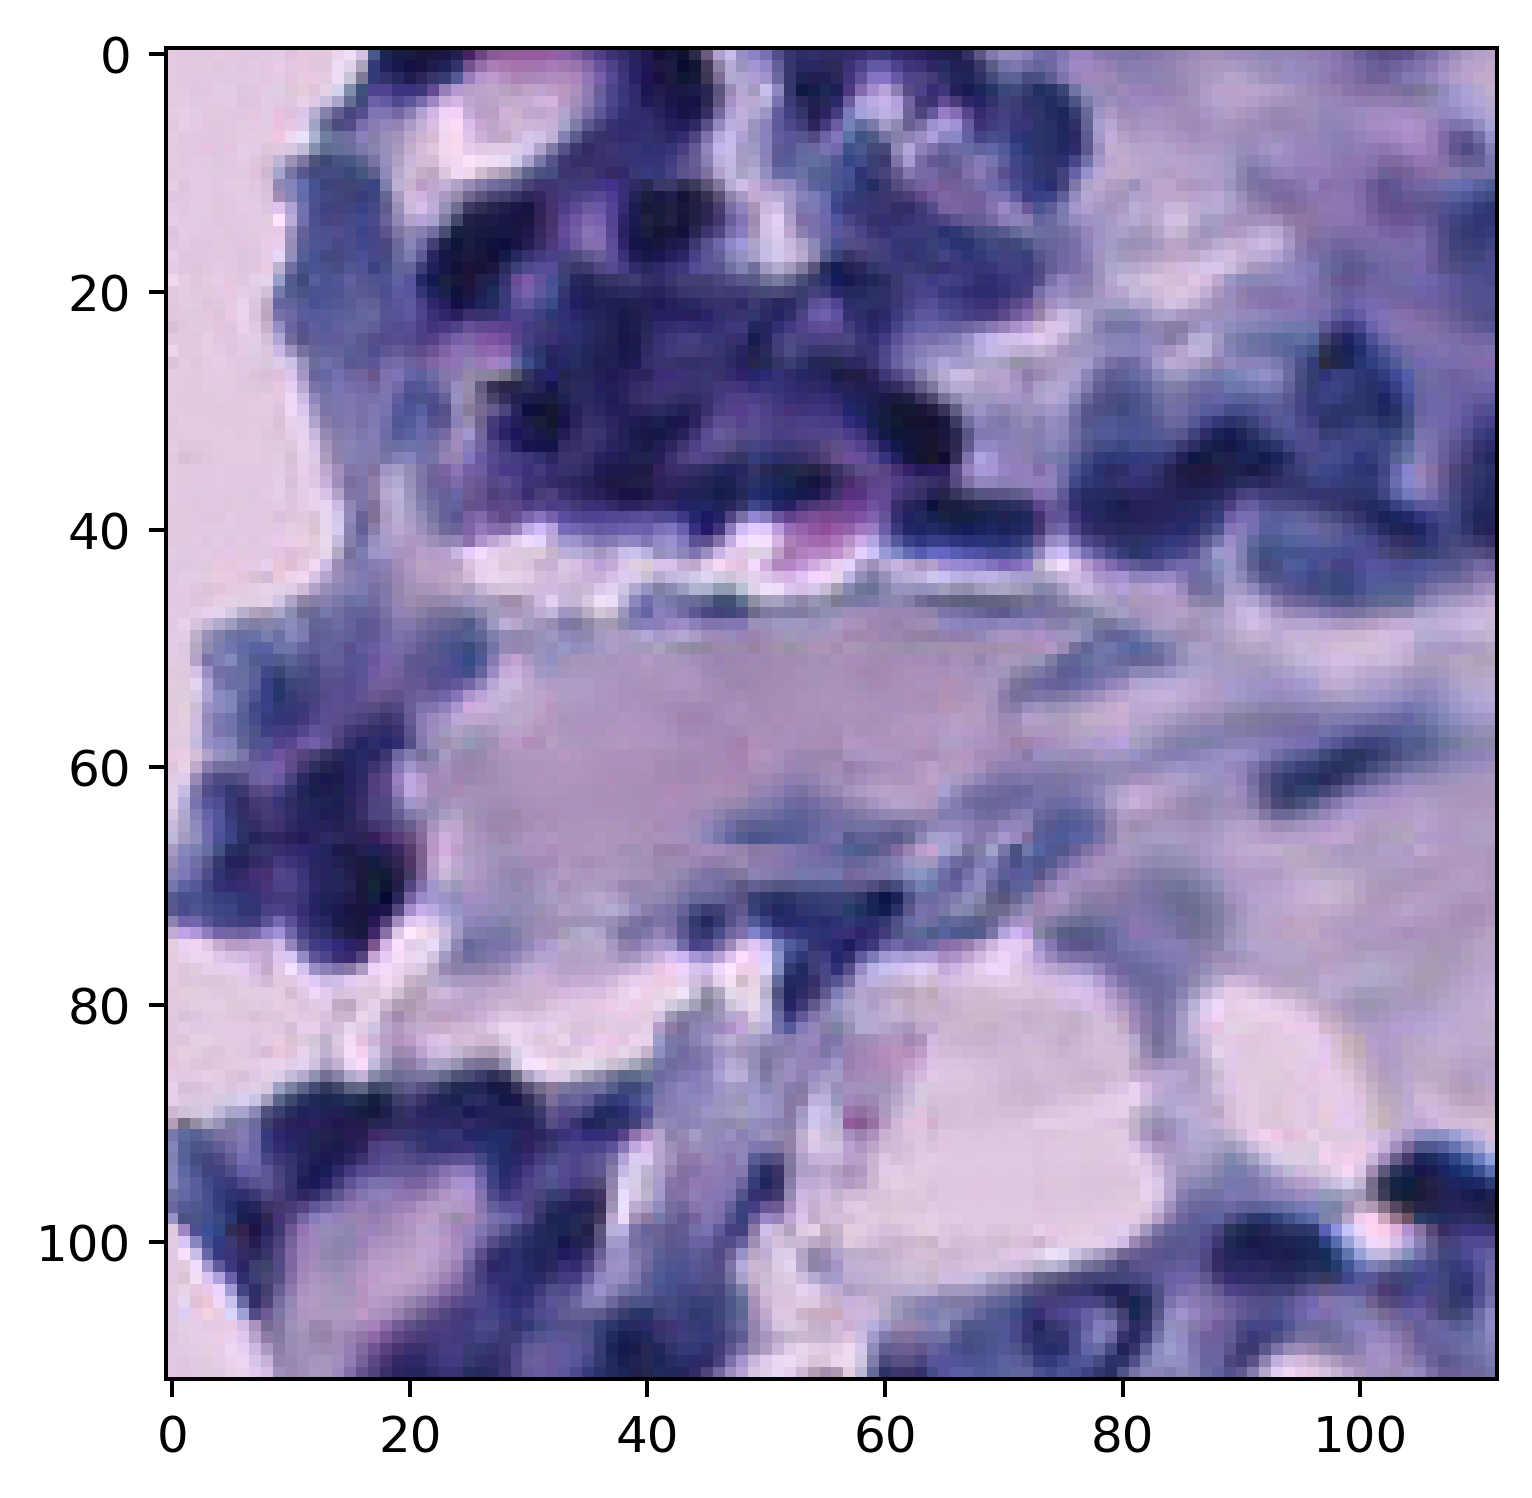

In [38]:
print(len(X), 'tissues')
print(len(X[0]), 'spots in the first tissue')
print('Label for the first spot in the first tissue:', y[0][0])
print('Image for the first spot in the first tissue')
img = np.transpose(X[0][0], [1, 2, 0])
plt.imshow(img)

In [39]:
X[0].shape

(346, 3, 112, 112)

In [40]:
y[0].shape

(346,)

<font color='blue'> Each spot has an associated label, from 0 to 6, so there are 7 classes in total. Here is the mapping from the integer label to the actual annotation of the tissue. </font>

In [41]:
lbl2id={'invasive cancer':0, 'breast glands':1, 'immune infiltrate':2,
        'cancer in situ':3, 'connective tissue':4, 'adipose tissue':5, 'undetermined':6}
id2lbl = dict(zip(lbl2id.values(), lbl2id.keys()))
id2lbl

{0: 'invasive cancer',
 1: 'breast glands',
 2: 'immune infiltrate',
 3: 'cancer in situ',
 4: 'connective tissue',
 5: 'adipose tissue',
 6: 'undetermined'}

In [42]:
# If you want, you can try to write code to visualise some images from each of the classes.
# The following may be helpful to get all the spots/labels available
# data = np.concatenate(X, axis=0)
# labels = np.concatenate(y, axis=0)

### 2.1 Deep learning model

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from PIL import Image


In [44]:
# Define the CNN architecture
class HNEClassifier(nn.Module):
    def __init__(self, num_classes):
        super(HNEClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


The given code represents a CNN (Convolutional Neural Network) model called "HNEClassifier" that is used for image classification tasks. Let's go through the structure and functionality of the model step by step:

1. **Initialization**: The `__init__` function initializes the model. It takes the parameter `num_classes` which represents the number of classes the model will classify the images into. It starts by calling the constructor of the parent class `nn.Module` using `super(HNEClassifier, self).__init__()`.

2. **Convolutional Layers**: The model begins with two convolutional layers:
   - `self.conv1`: This is the first convolutional layer. It takes input channels of 3 (representing RGB images), applies 16 filters with a kernel size of 3x3, a stride of 1, and padding of 1. This layer is responsible for extracting low-level features from the input image.
   - `self.conv2`: This is the second convolutional layer. It takes 16 input channels (output from the previous layer) and applies 32 filters with the same kernel size, stride, and padding as before. This layer further extracts more complex and abstract features from the input.

3. **Activation and Pooling**: After each convolutional layer, a ReLU activation function and a max pooling operation are applied to introduce non-linearity and downsample the feature maps, respectively.
   - `self.relu`: This is an instance of the ReLU activation function, applied after each convolutional layer.
   - `self.maxpool`: This is the max pooling layer. It performs a 2x2 pooling operation with a stride of 2, reducing the spatial dimensions of the feature maps by half.

4. **Flattening**: To connect the convolutional layers to the final fully connected layers, the feature maps need to be flattened into a vector representation. The `nn.Flatten()` layer is used to flatten the multi-dimensional feature maps into a 1D vector.

5. **Fully Connected Layers**: After flattening, the flattened features are fed into fully connected layers for classification.
   - `self.fc`: This is a linear layer (fully connected layer) that takes the flattened feature vector as input and produces the final output. The input size of this layer is calculated as 32 * 56 * 56, which corresponds to the number of channels (32) multiplied by the spatial dimensions (56x56) of the feature maps.

6. **Forward Pass**: The `forward` method defines the forward pass of the model, specifying how the input flows through the defined layers.
   - The input `x` is passed through the `conv1` layer, followed by the ReLU activation (`relu`) and max pooling (`maxpool`) operations.
   - The output from the previous operations is then passed through the `conv2` layer, ReLU activation, and max pooling again.
   - The resulting feature maps are flattened into a 1D vector using the `flatten` layer.
   - Finally, the flattened features are passed through the fully connected layer (`fc`) to produce the output logits.

7. **Output**: The output of the model is returned, which represents the predicted logits for each class. The logits can be further processed with a softmax function to obtain class probabilities.

In summary, the HNEClassifier model consists of two convolutional layers with ReLU activations and max pooling, followed by a flattening operation and a fully connected layer for classification. This architecture is commonly used for image classification tasks, extracting hierarchical features from input images and predicting class labels based on those features.

<font color='blue'> The model accepts input images of size 224x224. Let's write a transformation function that resizes the images to this size.  </font>

In [45]:
# Define data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


Here we define a dataloader that lets us iterate over the images and labels to train on.

In [46]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)



Let's merge all the spots from the 7 samples together.

In [47]:
data = np.concatenate(X, axis=0)
data.shape

(2868, 3, 112, 112)

In [48]:
labels = np.concatenate(y, axis=0)
labels.shape

(2868,)

We now split the data into training and test sets. 

In [49]:
from sklearn.model_selection import (  # we'll use this function to split our dataset in train and test set
    train_test_split,
)

X_train, X_test, y_train, y_test = train_test_split(
    data, labels,
    test_size=0.15,
    shuffle=True,
    random_state=42,
)

Let's look at the number of training and test instances.

In [50]:
print(X_train.shape)
print(X_test.shape)

(2437, 3, 112, 112)
(431, 3, 112, 112)


In [51]:
# Load the data into the dataloading functions
train_dataset = MyDataset(X_train, y_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64)

test_dataset = MyDataset(X_test, y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_dataset[0]

(tensor([[[0.2157, 0.2000, 0.1686,  ..., 0.1843, 0.1725, 0.1647],
          [0.2000, 0.1843, 0.1569,  ..., 0.1843, 0.1725, 0.1686],
          [0.1686, 0.1569, 0.1294,  ..., 0.1882, 0.1765, 0.1725],
          ...,
          [0.3804, 0.3608, 0.3255,  ..., 0.3529, 0.2667, 0.2196],
          [0.3529, 0.3333, 0.2941,  ..., 0.3176, 0.2392, 0.2000],
          [0.3373, 0.3176, 0.2784,  ..., 0.2980, 0.2235, 0.1882]],
 
         [[0.2627, 0.2471, 0.2157,  ..., 0.2471, 0.2353, 0.2275],
          [0.2471, 0.2314, 0.2039,  ..., 0.2471, 0.2353, 0.2275],
          [0.2157, 0.2039, 0.1765,  ..., 0.2431, 0.2314, 0.2275],
          ...,
          [0.4118, 0.3961, 0.3647,  ..., 0.3843, 0.3137, 0.2745],
          [0.3882, 0.3686, 0.3373,  ..., 0.3569, 0.2941, 0.2588],
          [0.3765, 0.3569, 0.3216,  ..., 0.3451, 0.2824, 0.2510]],
 
         [[0.4980, 0.4824, 0.4510,  ..., 0.4902, 0.4784, 0.4706],
          [0.4824, 0.4667, 0.4392,  ..., 0.4902, 0.4784, 0.4706],
          [0.4510, 0.4392, 0.4118,  ...,

<font color='blue'> We can verify that our dataloader is indeed returning an image and label. </font>

Label: tensor(6)


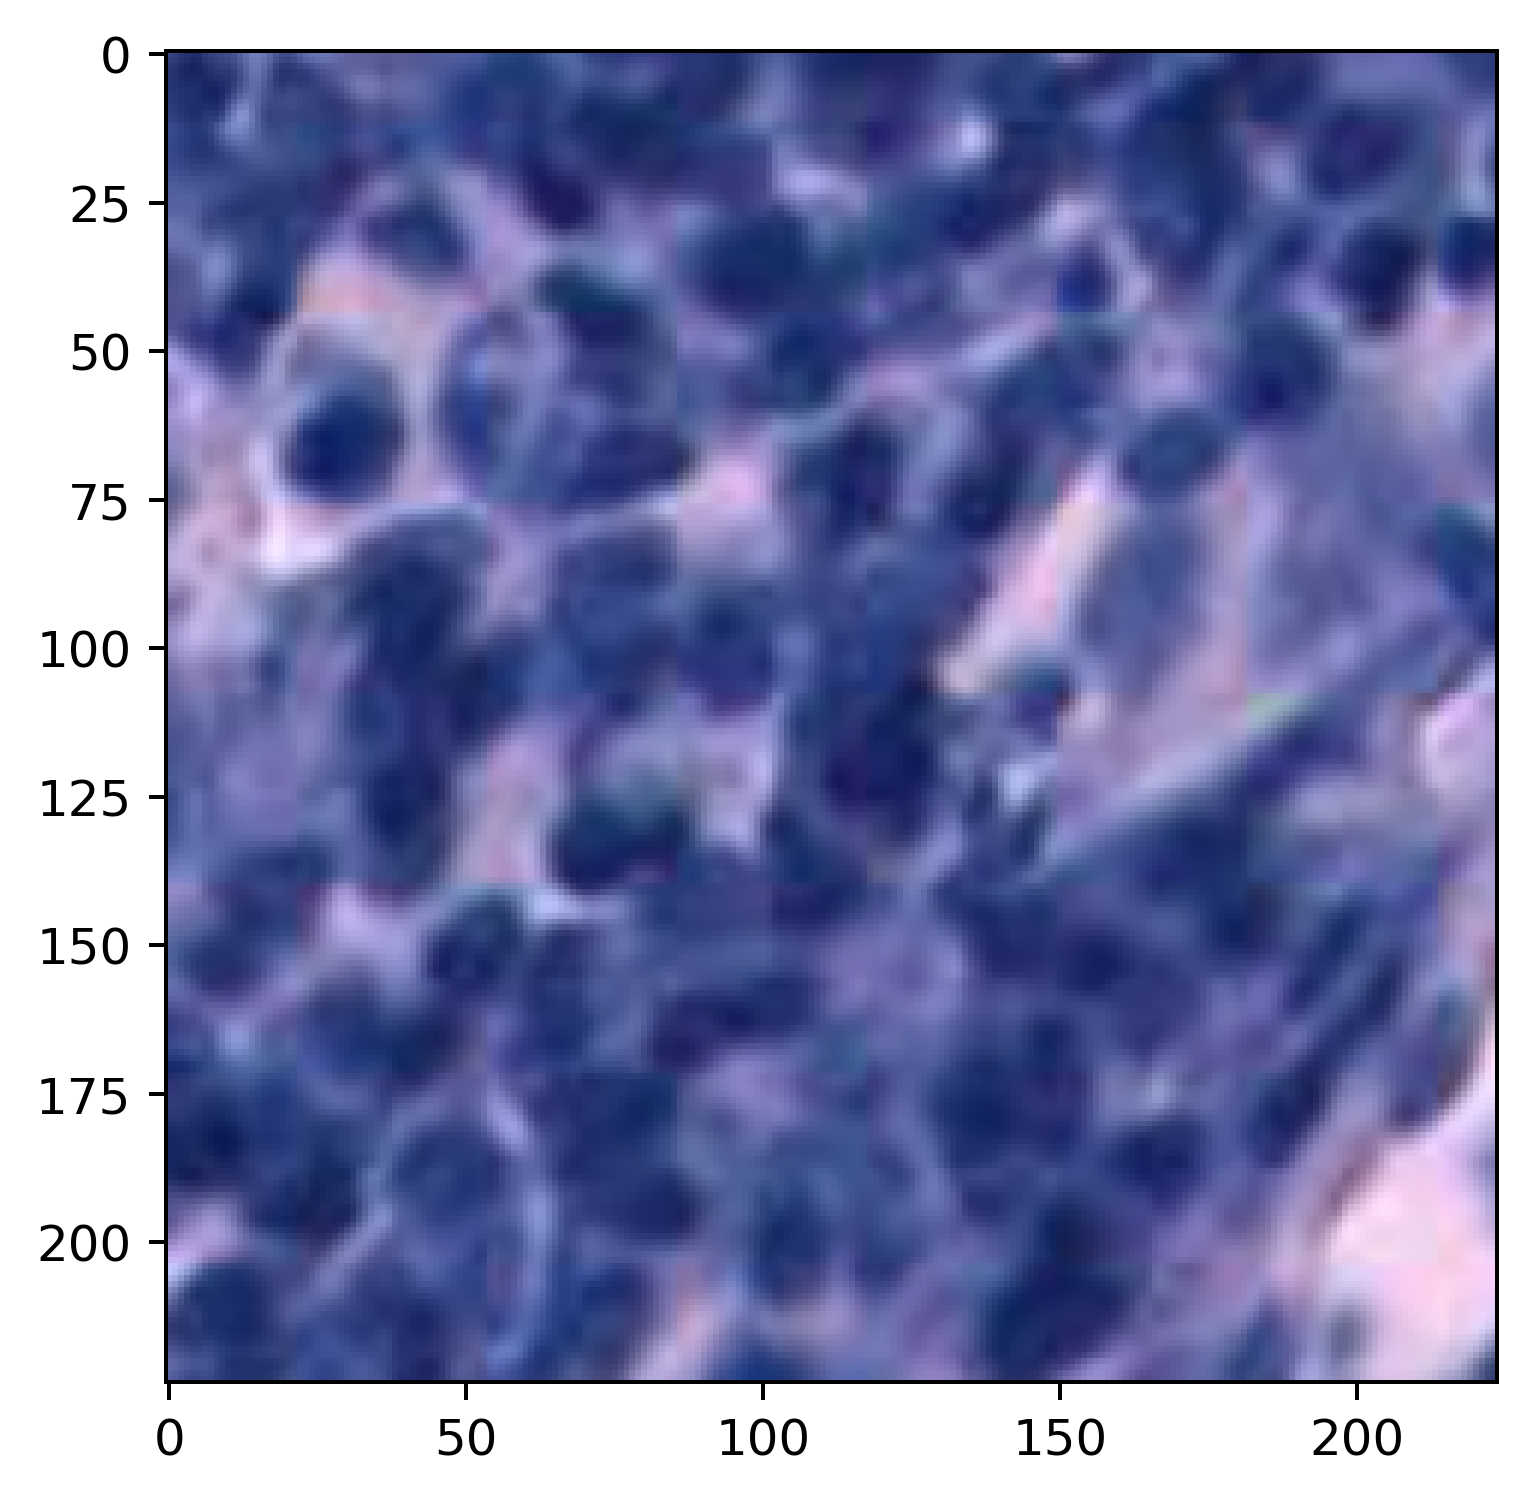

In [52]:
plt.imshow(train_dataset[0][0].permute(1, 2, 0)  )
print("Label:",train_dataset[0][1])

### 2.2 Training

In [53]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 10


In [54]:
# Initialize the model
model = HNEClassifier(num_classes=7).to(device)


We can see the dimensions of the input shape through each layer of the network using the `torchinfo` package.

We can see that the model correctly outputs 7 logits for the 7 possible classes.

In [55]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [56]:
# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = 0.0
    model.train()  # Set the model to training mode

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        train_loss += loss.item()

    # Calculate average training loss for the epoch
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    val_loss = 0.0
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Accumulate validation loss
            val_loss += loss.item()

        # Calculate average validation loss for the epoch
        val_loss /= len(test_loader)
        val_losses.append(val_loss)

    # Print training and validation losses for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch [1/10], Training Loss: 1.4661, Validation Loss: 1.1936
Epoch [2/10], Training Loss: 1.0800, Validation Loss: 1.0885
Epoch [3/10], Training Loss: 0.9828, Validation Loss: 1.0594
Epoch [4/10], Training Loss: 0.9550, Validation Loss: 1.0994
Epoch [5/10], Training Loss: 0.8892, Validation Loss: 1.0914
Epoch [6/10], Training Loss: 0.8257, Validation Loss: 1.1318
Epoch [7/10], Training Loss: 0.7474, Validation Loss: 1.1877
Epoch [8/10], Training Loss: 0.6714, Validation Loss: 1.2184
Epoch [9/10], Training Loss: 0.5805, Validation Loss: 1.2656
Epoch [10/10], Training Loss: 0.4910, Validation Loss: 1.3772


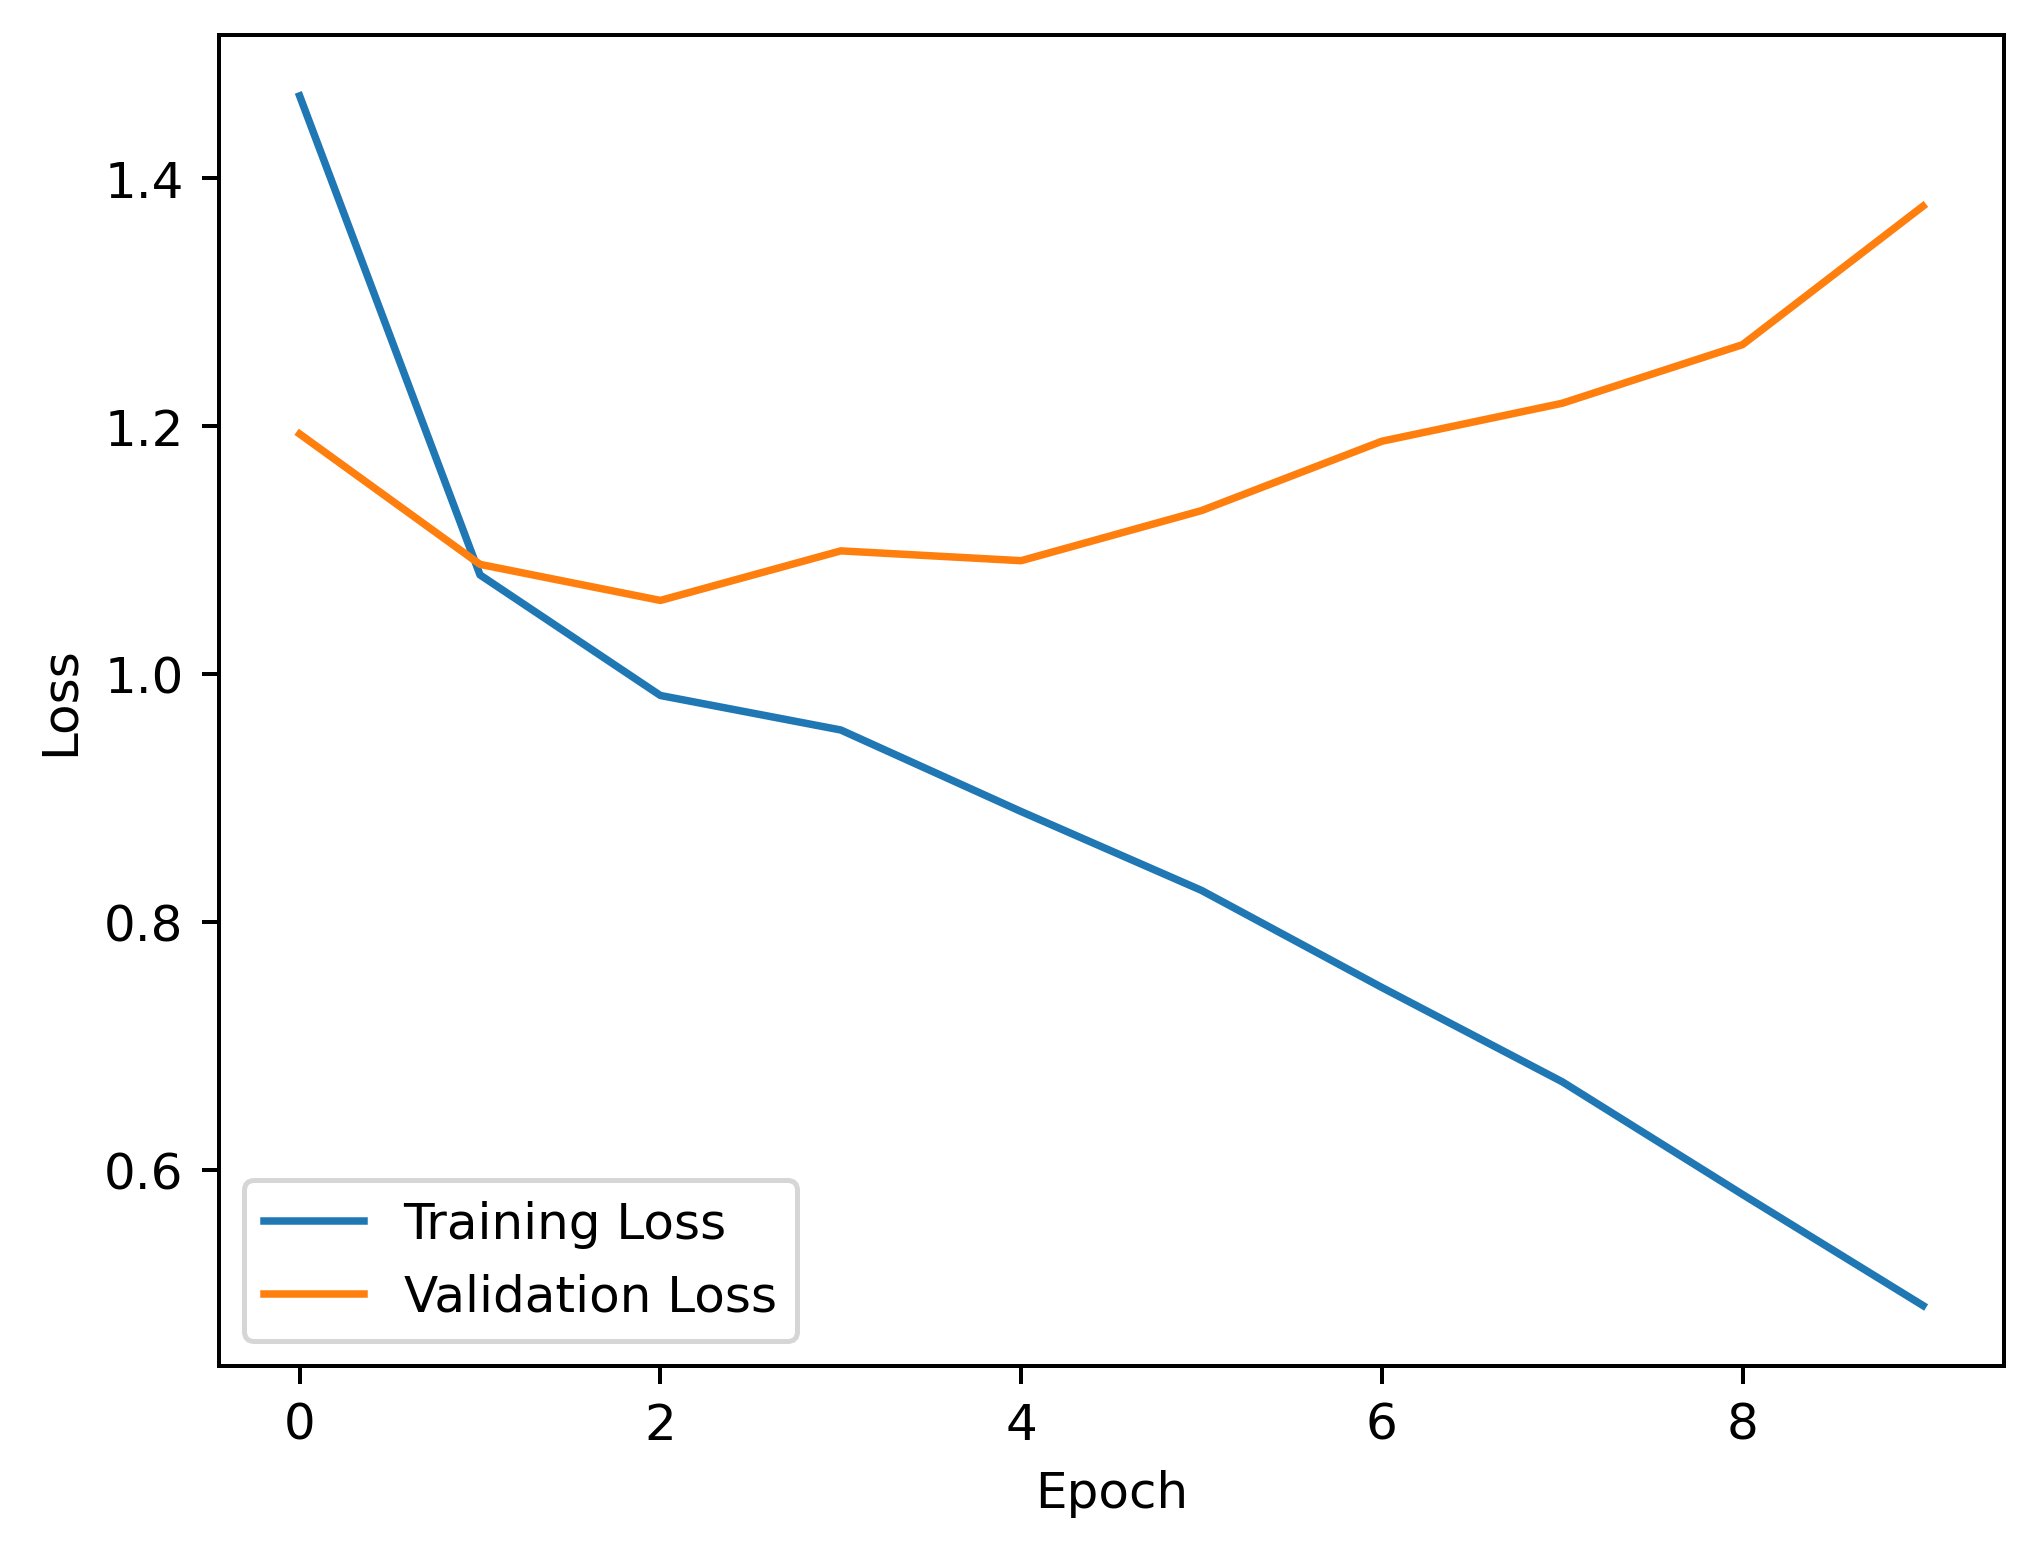

In [57]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<font color='purple'> **Question**: The training loss is decreasing every epoch but the validation loss is increasing. What might be happening here? Think of possible explanations for this phenomenon. </font>